In [15]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn.preprocessing as skl_pre
import sklearn.linear_model as skl_lm
import sklearn.discriminant_analysis as skl_da
import sklearn.neighbors as skl_nb
import sklearn.model_selection as skl_ms

import seaborn as sns

from sklearn import tree
from sklearn.ensemble import IsolationForest, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

#import graphviz

Perform model training and validation to get a baseline performance

In [16]:
##########################
# RandomForestClassifier #
##########################

# Load train.csv
csv = pd.read_csv('data/train.csv')

# 'Number of words lead', 'Year', 'Gross', 'Number of words lead', 'Mean Age Male', 'Mean Age Female'
# 'Mean Age Male', 'Gross', 'Year'
X_csv = csv.drop(columns=['Lead'])
y_csv = csv['Lead']

n_fold = 5

skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
lst_accu_stratified = []

for i, (train_index, val_index) in enumerate(skf.split(X_csv, y_csv)):
    
    print(i)
    
    X_train, X_val = X_csv.iloc[train_index], X_csv.iloc[val_index]
    y_train, y_val = y_csv.iloc[train_index], y_csv.iloc[val_index]

    model_rf_base = RandomForestClassifier()
    model_rf_base.fit(X=X_train, y=y_train)
    y_predict = model_rf_base.predict(X_val)
    
    lst_accu_stratified.append(model_rf_base.score(X_val, y_val))

print('\nBase line performance:')
print('Maximum Accuracy:',
      max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified))

0
1
2
3
4

Base line performance:
Maximum Accuracy: 84.05797101449275 %
Minimum Accuracy: 82.21153846153845 %
Overall Accuracy: 83.06159420289855 %
Standard Deviation is: 0.0068494358066978666


Now, start to tunning the parameters.

In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
 }

rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = params, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_csv, y_csv)

print("\nTune model parameters (RandomizedSearchCV):")
print(rf_random.best_params_)

n_estimators_1 = rf_random.best_params_['n_estimators']
max_depth_1 = rf_random.best_params_['max_depth']
min_samples_split_1 = rf_random.best_params_['min_samples_split']
min_samples_leaf_1 = rf_random.best_params_['min_samples_leaf']
bootstrap_1 = rf_random.best_params_['bootstrap']

skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
lst_accu_stratified = []

for i, (train_index, val_index) in enumerate(skf.split(X_csv, y_csv)):
    
    print(i)
    
    X_train, X_val = X_csv.iloc[train_index], X_csv.iloc[val_index]
    y_train, y_val = y_csv.iloc[train_index], y_csv.iloc[val_index]

    model_rf_para = RandomForestClassifier(n_estimators=n_estimators_1,min_samples_split=min_samples_split_1,min_samples_leaf=min_samples_leaf_1,max_depth=max_depth_1,bootstrap=bootstrap_1)
    model_rf_para.fit(X=X_train, y=y_train)
    y_predict = model_rf_para.predict(X_val)
    
    lst_accu_stratified.append(model_rf_para.score(X_val, y_val))

print('\nTune model parameters performance (RandomizedSearchCV):')
print('Maximum Accuracy:',
      max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified))

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Tune model parameters (RandomizedSearchCV):
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 90, 'bootstrap': False}
0
1
2
3
4

Tune model parameters performance (RandomizedSearchCV):
Maximum Accuracy: 87.43961352657004 %
Minimum Accuracy: 83.17307692307693 %
Overall Accuracy: 85.27638424377555 %
Standard Deviation is: 0.019830939015243146


In [19]:
# Number of trees in random forest
n_estimators = [500, 600, 700]

# Maximum number of levels in tree
max_depth = [80, 90, 100]

# Minimum number of samples required to split a node
min_samples_split = [3, 5, 7]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]

# Method of selecting samples for training each tree
bootstrap = [False]

params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
 }


grid_cv = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5, verbose=2, n_jobs=-1)
grid_cv.fit(X_csv,y_csv)
print("\nTune model parameters (GridSearchCV):")
print(grid_cv.best_params_)
print(grid_cv.best_score_)

n_estimators_2 = grid_cv.best_params_['n_estimators']
max_depth_2 = grid_cv.best_params_['max_depth']
min_samples_split_2 = grid_cv.best_params_['min_samples_split']
min_samples_leaf_2 = grid_cv.best_params_['min_samples_leaf']
bootstrap_2 = grid_cv.best_params_['bootstrap']

skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
lst_accu_stratified = []

for i, (train_index, val_index) in enumerate(skf.split(X_csv, y_csv)):
    
    print(i)
    
    X_train, X_val = X_csv.iloc[train_index], X_csv.iloc[val_index]
    y_train, y_val = y_csv.iloc[train_index], y_csv.iloc[val_index]

    model_rf_para = RandomForestClassifier(n_estimators=n_estimators_2,min_samples_split=min_samples_split_2,min_samples_leaf=min_samples_leaf_2,max_depth=max_depth_2,bootstrap=bootstrap_2)
    model_rf_para.fit(X=X_train, y=y_train)
    y_predict = model_rf_para.predict(X_val)
    
    lst_accu_stratified.append(model_rf_para.score(X_val, y_val))

print('\nTune model parameters performance (GridSearchCV):')
print('Maximum Accuracy:',
      max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified))

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Tune model parameters (GridSearchCV):
{'bootstrap': False, 'max_depth': 90, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
0.8507850241545892
0
1
2
3
4

Tune model parameters performance (GridSearchCV):
Maximum Accuracy: 87.43961352657004 %
Minimum Accuracy: 83.65384615384616 %
Overall Accuracy: 85.08407655146786 %
Standard Deviation is: 0.015718393668196544



Feature importances:


<AxesSubplot:>

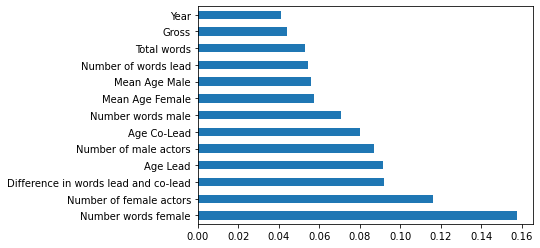

In [22]:
print('\nFeature importances:')
feat_importance_rf = pd.Series(model_rf_para.feature_importances_, index= X_csv.columns)
feat_importance_rf.nlargest(13).plot(kind='barh')


Feature correlation matrix:


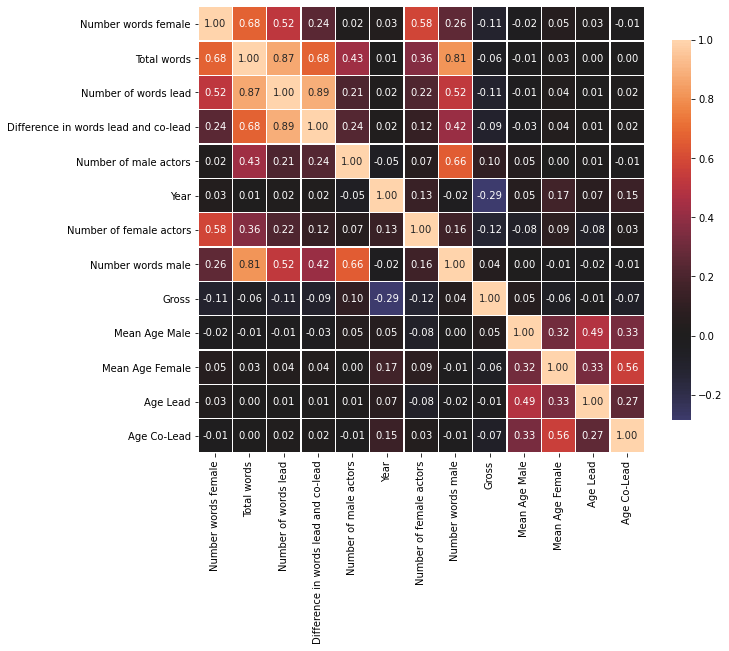

In [23]:
print('\nFeature correlation matrix:')
Numeric_df = pd.DataFrame(X_csv)
corr= Numeric_df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show()

In [32]:
print('\nFeature selection:')

# 'Number of words lead', 'Year', 'Gross', 'Number of words lead', 'Mean Age Male', 'Mean Age Female'
# 'Mean Age Male', 'Gross', 'Year'
X_csv = csv.drop(columns=['Lead','Gross','Year','Total words'])
y_csv = csv['Lead']

skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=1)
lst_accu_stratified = []

for i, (train_index, val_index) in enumerate(skf.split(X_csv, y_csv)):
    
    print(i)
    
    X_train, X_val = X_csv.iloc[train_index], X_csv.iloc[val_index]
    y_train, y_val = y_csv.iloc[train_index], y_csv.iloc[val_index]

    model_rf_base = RandomForestClassifier(n_estimators=n_estimators_1,min_samples_split=min_samples_split_1,min_samples_leaf=min_samples_leaf_1,max_depth=max_depth_1,bootstrap=bootstrap_1)
    model_rf_base.fit(X=X_train, y=y_train)
    y_predict = model_rf_base.predict(X_val)
    
    lst_accu_stratified.append(model_rf_base.score(X_val, y_val))

print('\nFeature selection performance:')
print('Maximum Accuracy:',
      max(lst_accu_stratified)*100, '%')
print('Minimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('Overall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('Standard Deviation is:', stdev(lst_accu_stratified))


Feature selection:
0
1
2
3
4

Feature selection performance:
Maximum Accuracy: 87.92270531400966 %
Minimum Accuracy: 84.61538461538461 %
Overall Accuracy: 86.23838721664808 %
Standard Deviation is: 0.015642021731736344
